In [1]:
# ---------------------------- 1. 导入所有依赖库 ----------------------------
import pandas as pd  # 读取Excel数据、处理表格
import numpy as np   # 数值计算（数组、矩阵操作）
import matplotlib.pyplot as plt  # 绘制可视化图表
import seaborn as sns  # 增强型可视化（特征重要性、相关性图）
from sklearn.preprocessing import MinMaxScaler  # 数据归一化（消除量纲影响）
from sklearn.model_selection import (
    train_test_split,  # 划分训练集/测试集
    GridSearchCV       # 超参数网格搜索优化
)
from sklearn.metrics import (
    mean_squared_error,  # 计算均方误差（MSE）
    r2_score             # 计算拟合优度（R²，衡量预测准确性）
)
from sklearn.ensemble import RandomForestRegressor  # 随机森林回归（非线性模型）
from sklearn.linear_model import Ridge, RidgeCV     # 岭回归（线性模型，抗过拟合）
from sklearn.feature_selection import mutual_info_regression  # 互信息特征筛选
from sklearn.model_selection import learning_curve  # 学习曲线
from sklearn.base import clone  # 模型克隆
import warnings
warnings.filterwarnings('ignore')  # 忽略无关警告（如版本兼容提示）

# 设置中文字体（解决matplotlib中文乱码问题）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


In [2]:
# ---------------------------- 2. 数据读取与基础预处理 ----------------------------
print("="*60)
print("2. 数据读取与基础预处理")
print("="*60)

# 读取Excel数据
file_path = r"C:\Users\lenovo\Desktop\材料数据挖掘利用方法-机器学习与数据挖掘\0大作业目标数据集.xlsx" 
df = pd.read_excel(file_path, sheet_name="10year", engine='openpyxl')  # 读取10year表

# 数据基础信息查看
print(f"数据形状：{df.shape} → 共{df.shape[0]}个样本，{df.shape[1]}个特征/目标变量")
print(f"\n数据列名（特征+目标变量）：")
print(df.columns.tolist())
print(f"\n数据前5行预览：")
print(df.head())
print(f"\n数据缺失值统计：")
print(df.isnull().sum())

# 定义输入特征（X）与目标变量（y）
X = df.drop(columns=['RATE']).copy()  # 输入特征（元素成分+环境参数）
y = df['RATE'].copy()                # 目标变量（腐蚀速率）
print()
print(f"\n输入特征形状：{X.shape}，目标变量形状：{y.shape}")

# 数据归一化（消除特征间量纲差异）
scaler_X = MinMaxScaler(feature_range=(0, 1))  # 特征归一化器
scaler_y = MinMaxScaler(feature_range=(0, 1))  # 目标变量归一化器

X_scaled = scaler_X.fit_transform(X)  # 特征归一化
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()  # 目标变量归一化

# 划分训练集与测试集（8:2）
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)
print()
print(f"\n数据集拆分结果：")
print(f"训练集：X_train({X_train.shape}) | y_train({y_train.shape})")
print(f"测试集：X_test({X_test.shape}) | y_test({y_test.shape})")


2. 数据读取与基础预处理
数据形状：(89, 22) → 共89个样本，22个特征/目标变量

数据列名（特征+目标变量）：
['C', 'Si', 'Mn', 'P', 'S', 'Cu', 'Cr', 'Ni', 'T_MAX', 'T_MIN', 'T_AVE', 'RH_AVE', 'SUN', 'TOW', 'PRECIPIT', 'WIND_MAX', 'WIND_AVE', 'SOLAR', 'ULTRA', 'Cl', 'SO2', 'RATE']

数据前5行预览：
       C     Si     Mn       P       S     Cu     Cr     Ni  T_MAX  T_MIN  \
0  0.001  0.003  0.003  0.0006  0.0007  0.430  0.005  0.003   36.6   -4.4   
1  0.001  0.003  0.010  0.0003  0.0001  0.009  0.005  0.980   36.6   -4.4   
2  0.001  0.003  0.010  0.0005  0.0002  0.009  0.005  3.020   36.6   -4.4   
3  0.001  0.003  0.110  0.0006  0.0003  0.009  0.005  5.010   36.6   -4.4   
4  0.001  0.003  0.120  0.0005  0.0003  0.009  0.005  9.060   36.6   -4.4   

   ...     SUN     TOW  PRECIPIT  WIND_MAX  WIND_AVE   SOLAR  ULTRA   Cl  SO2  \
0  ...  1457.6  4088.1    1270.1      10.6       1.5  4182.8  181.9  2.8  3.7   
1  ...  1457.6  4088.1    1270.1      10.6       1.5  4182.8  181.9  2.8  3.7   
2  ...  1457.6  4088.1    1270.1      10.6      


3. 特征筛选（互信息回归+随机森林特征重要性）

互信息回归特征重要性：
     Feature  MI_Score
17     SOLAR  0.971973
13       TOW  0.951285
14  PRECIPIT  0.930565
15  WIND_MAX  0.908609
8      T_MAX  0.907033
16  WIND_AVE  0.882413
19        Cl  0.880635
12       SUN  0.841452
9      T_MIN  0.840219
18     ULTRA  0.834579
11    RH_AVE  0.824807
10     T_AVE  0.814425
20       SO2  0.802981
4          S  0.136711
6         Cr  0.048797
1         Si  0.036532
7         Ni  0.033125
0          C  0.019902
2         Mn  0.000000
3          P  0.000000
5         Cu  0.000000

 随机森林特征重要性：
     Feature  RF_Importance
10     T_AVE       0.301721
20       SO2       0.165036
19        Cl       0.065989
18     ULTRA       0.057541
16  WIND_AVE       0.057028
8      T_MAX       0.051738
4          S       0.040967
15  WIND_MAX       0.032021
11    RH_AVE       0.031211
12       SUN       0.030435
9      T_MIN       0.026668
0          C       0.025653
2         Mn       0.021532
5         Cu       0.019384
13       TOW       0.0

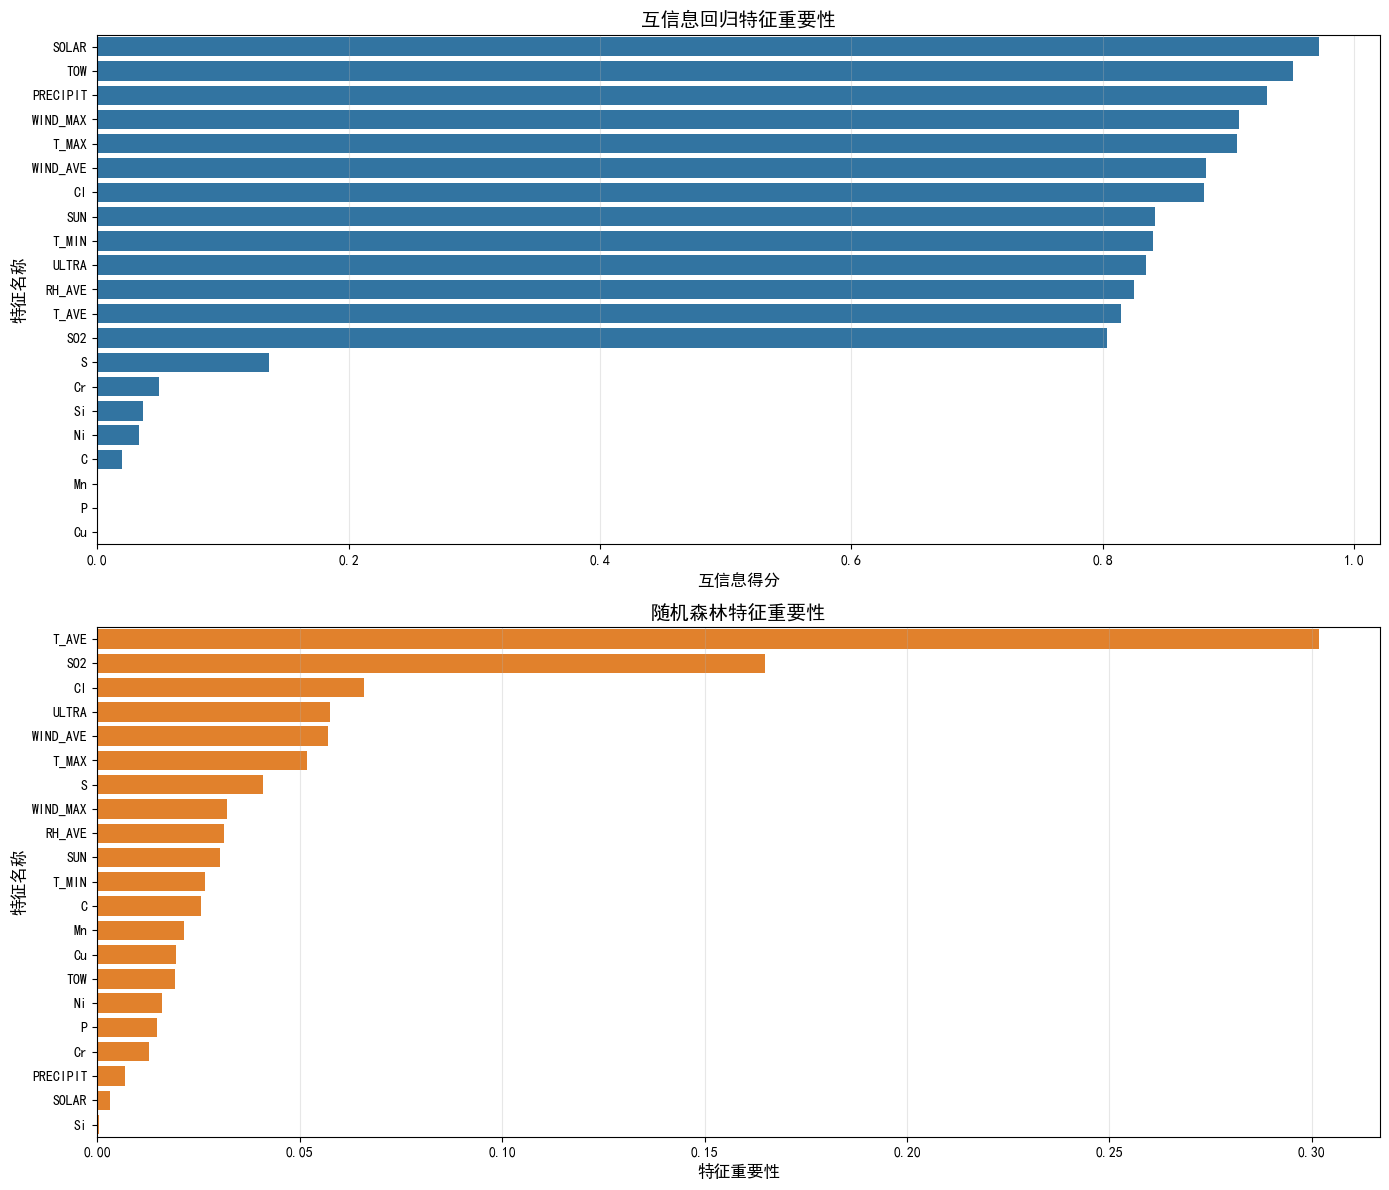


 最终筛选的输入特征（10个）：
['T_MAX', 'ULTRA', 'WIND_MAX', 'WIND_AVE', 'SUN', 'Cl', 'SOLAR', 'TOW', 'PRECIPIT', 'T_MIN']

筛选后数据形状：
训练集：X_train_final((71, 10)) | 测试集：X_test_final((18, 10))

 前10个重要特征对比可视化：


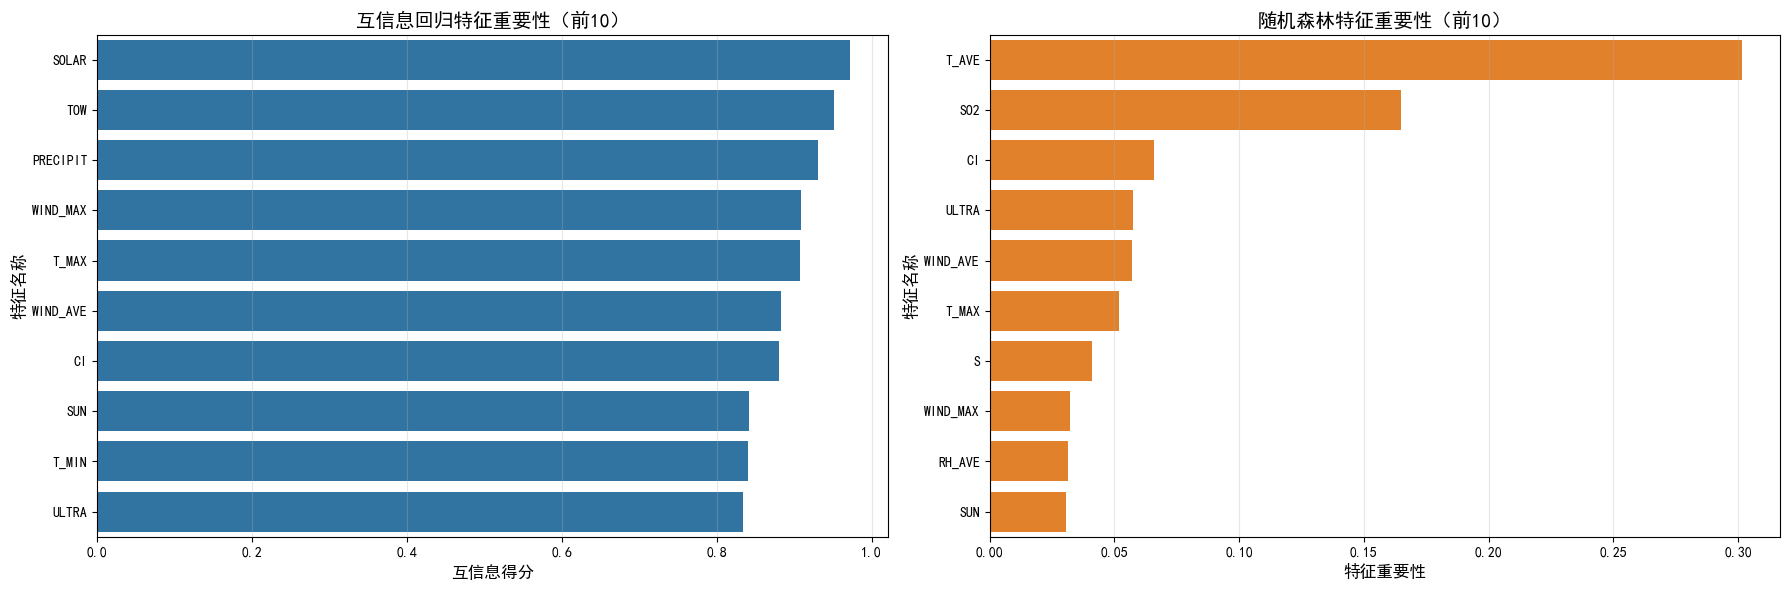


两种方法特征重要性对比：


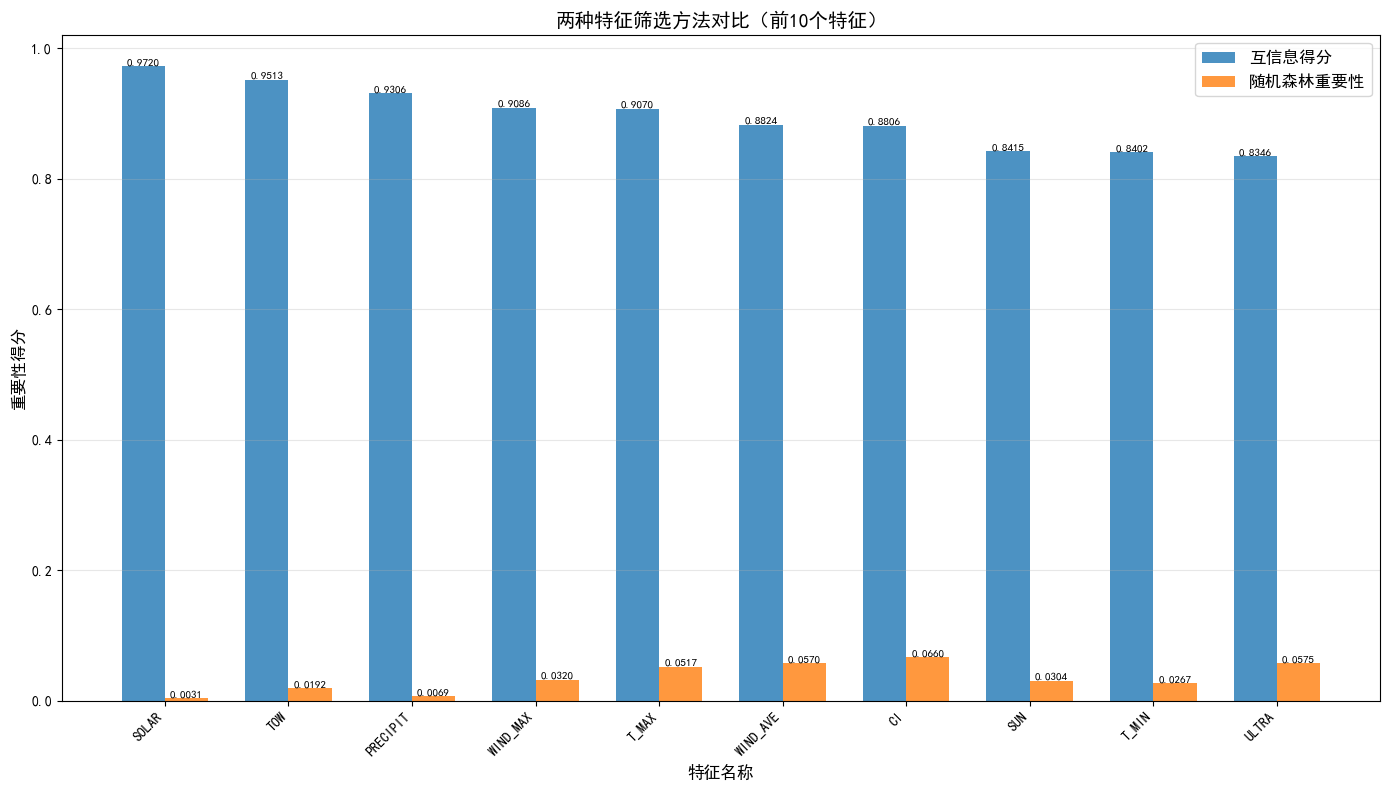

In [3]:
# ---------------------------- 3. 特征筛选 互信息回归 与 随机森林特征 ----------------------------
print("\n" + "="*60)
print("3. 特征筛选（互信息回归+随机森林特征重要性）")
print("="*60)

# 互信息回归（衡量非线性相关性）
mi_scores = mutual_info_regression(X_train, y_train)  # 计算互信息得分
mi_result = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

print(f"\n互信息回归特征重要性：")
print(mi_result)

# 3.2 随机森林特征重要性
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X_train, y_train)
rf_importance_result = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': rf_temp.feature_importances_
}).sort_values(by='RF_Importance', ascending=False)

print(f"\n 随机森林特征重要性：")
print(rf_importance_result)

#  所有特征重要性可视化
print("\n 所有特征重要性可视化：")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# 互信息回归所有特征重要性
sns.barplot(x='MI_Score', y='Feature', data=mi_result, ax=ax1, color='#1f77b4')
ax1.set_title('互信息回归特征重要性', fontsize=14, fontweight='bold')
ax1.set_xlabel('互信息得分', fontsize=12)
ax1.set_ylabel('特征名称', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

# 随机森林所有特征重要性
sns.barplot(x='RF_Importance', y='Feature', data=rf_importance_result, ax=ax2, color='#ff7f0e')
ax2.set_title('随机森林特征重要性', fontsize=14, fontweight='bold')
ax2.set_xlabel('特征重要性', fontsize=12)
ax2.set_ylabel('特征名称', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#  确定最终输入特征（取两种方法的交集，不足10个则用互信息补充）
mi_top10 = mi_result.head(10)['Feature'].tolist()
rf_top10 = rf_importance_result.head(10)['Feature'].tolist()
final_features = list(set(mi_top10) & set(rf_top10))
if len(final_features) < 10:
    supplement = [f for f in mi_top10 if f not in final_features]
    final_features += supplement[:10 - len(final_features)]

print(f"\n 最终筛选的输入特征（{len(final_features)}个）：")
print(final_features)

# 筛选后的数据
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_train_final = X_train_df[final_features].values  # 训练集最终特征
X_test_final = X_test_df[final_features].values    # 测试集最终特征
print(f"\n筛选后数据形状：")
print(f"训练集：X_train_final({X_train_final.shape}) | 测试集：X_test_final({X_test_final.shape})")

#  前10个重要特征对比可视化
print("\n 前10个重要特征对比可视化：")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# 互信息回归前10个特征重要性
sns.barplot(x='MI_Score', y='Feature', data=mi_result.head(10), ax=ax1, color='#1f77b4')
ax1.set_title('互信息回归特征重要性（前10）', fontsize=14, fontweight='bold')
ax1.set_xlabel('互信息得分', fontsize=12)
ax1.set_ylabel('特征名称', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

# 随机森林前10个特征重要性
sns.barplot(x='RF_Importance', y='Feature', data=rf_importance_result.head(10), ax=ax2, color='#ff7f0e')
ax2.set_title('随机森林特征重要性（前10）', fontsize=14, fontweight='bold')
ax2.set_xlabel('特征重要性', fontsize=12)
ax2.set_ylabel('特征名称', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# 两种方法特征重要性对比（前10个特征）
print("\n两种方法特征重要性对比：")

# 创建对比数据
comparison_data = []
for feature in mi_result.head(10)['Feature']:
    mi_score = mi_result[mi_result['Feature'] == feature]['MI_Score'].values[0]
    rf_importance = rf_importance_result[rf_importance_result['Feature'] == feature]['RF_Importance'].values[0]
    comparison_data.append({
        'Feature': feature,
        'MI_Score': mi_score,
        'RF_Importance': rf_importance
    })

comparison_df = pd.DataFrame(comparison_data)

# 绘制对比图
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['MI_Score'], width, label='互信息得分', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['RF_Importance'], width, label='随机森林重要性', color='#ff7f0e', alpha=0.8)

ax.set_xlabel('特征名称', fontsize=12)
ax.set_ylabel('重要性得分', fontsize=12)
ax.set_title('两种特征筛选方法对比（前10个特征）', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Feature'], rotation=45, ha='right')
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

# 在柱状图上添加数值标签
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.show()


In [4]:
# ---------------------------- 4. 模型构建与超参数优化 随机森林回归 与 岭回归 ----------------------------
print("\n" + "="*60)
print("4. 模型构建与超参数优化（随机森林+岭回归）")
print("="*60)

# 模型1：随机森林回归
#  定义超参数网格
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

#  网格搜索优化超参数
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
rf_grid.fit(X_train_final, y_train)

#  最佳随机森林模型
best_rf = rf_grid.best_estimator_
print(f"\n 随机森林最佳超参数：")
print(rf_grid.best_params_)
# 4.1.4 随机森林预测
y_train_pred_rf = best_rf.predict(X_train_final)
y_test_pred_rf = best_rf.predict(X_test_final)

# 反归一化（转回原始尺度）
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_train_pred_rf_original = scaler_y.inverse_transform(y_train_pred_rf.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_pred_rf_original = scaler_y.inverse_transform(y_test_pred_rf.reshape(-1, 1)).flatten()

#  随机森林性能评估
rf_train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_rf_original))
rf_train_r2 = r2_score(y_train_original, y_train_pred_rf_original)
rf_test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred_rf_original))
rf_test_r2 = r2_score(y_test_original, y_test_pred_rf_original)

print(f"\n随机森林性能指标：")
print(f"训练集 - RMSE：{rf_train_rmse:.6f} | R²：{rf_train_r2:.6f}")
print(f"测试集 - RMSE：{rf_test_rmse:.6f} | R²：{rf_test_r2:.6f}")


# 模型2：岭回归
#  超参数优化（选择最佳alpha）
alphas = 10 ** np.linspace(-5, 5, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
ridge_cv.fit(X_train_final, y_train)

# 最佳岭回归模型
best_ridge = Ridge(alpha=ridge_cv.alpha_)
best_ridge.fit(X_train_final, y_train)
print(f"\n 岭回归最佳超参数（alpha）：{ridge_cv.alpha_:.6f}")
print(f"岭回归系数（各特征对腐蚀速率的影响程度）：")
for feat, coef in zip(final_features, best_ridge.coef_):
    print(f"  {feat}: {coef:.6f}")

#  岭回归预测
y_train_pred_ridge = best_ridge.predict(X_train_final)
y_test_pred_ridge = best_ridge.predict(X_test_final)

# 反归一化
y_train_pred_ridge_original = scaler_y.inverse_transform(y_train_pred_ridge.reshape(-1, 1)).flatten()
y_test_pred_ridge_original = scaler_y.inverse_transform(y_test_pred_ridge.reshape(-1, 1)).flatten()

# 岭回归性能评估
ridge_train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_ridge_original))
ridge_train_r2 = r2_score(y_train_original, y_train_pred_ridge_original)
ridge_test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred_ridge_original))
ridge_test_r2 = r2_score(y_test_original, y_test_pred_ridge_original)

print(f"\n岭回归性能指标：")
print(f"训练集 - RMSE：{ridge_train_rmse:.6f} | R²：{ridge_train_r2:.6f}")
print(f"测试集 - RMSE：{ridge_test_rmse:.6f} | R²：{ridge_test_r2:.6f}")

# 最佳模型选择
best_model = best_rf if rf_test_r2 > ridge_test_r2 else best_ridge
best_model_name = "随机森林" if rf_test_r2 > ridge_test_r2 else "岭回归"
best_test_r2 = max(rf_test_r2, ridge_test_r2)
best_test_rmse = min(rf_test_rmse, ridge_test_rmse)
print(f"\n 最佳模型：{best_model_name}")
print(f"最佳模型测试集性能：RMSE={best_test_rmse:.6f} | R²={best_test_r2:.6f}")



4. 模型构建与超参数优化（随机森林+岭回归）

 随机森林最佳超参数：
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

随机森林性能指标：
训练集 - RMSE：0.020012 | R²：0.846950
测试集 - RMSE：0.022039 | R²：0.821833

 岭回归最佳超参数（alpha）：0.000521
岭回归系数（各特征对腐蚀速率的影响程度）：
  T_MAX: -0.150956
  ULTRA: -3.709707
  WIND_MAX: -0.763161
  WIND_AVE: 1.572878
  SUN: 0.563827
  Cl: 2.182232
  SOLAR: 2.782748
  TOW: 0.647532
  PRECIPIT: -1.017827
  T_MIN: -0.156092

岭回归性能指标：
训练集 - RMSE：0.020074 | R²：0.846008
测试集 - RMSE：0.022376 | R²：0.816335

 最佳模型：随机森林
最佳模型测试集性能：RMSE=0.022039 | R²=0.821833



5. 模型性能可视化（真实值vs预测值散点图）


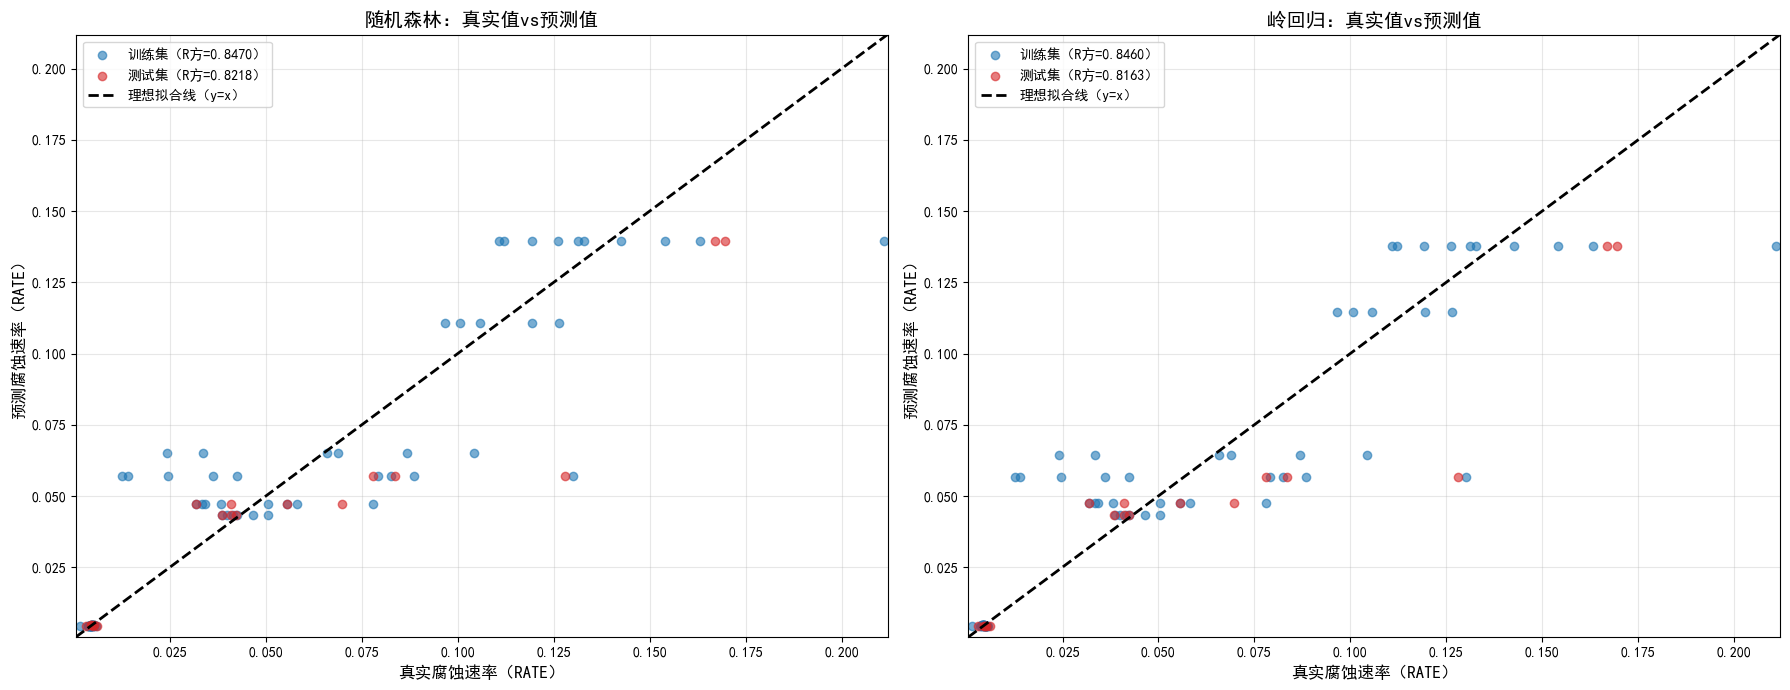

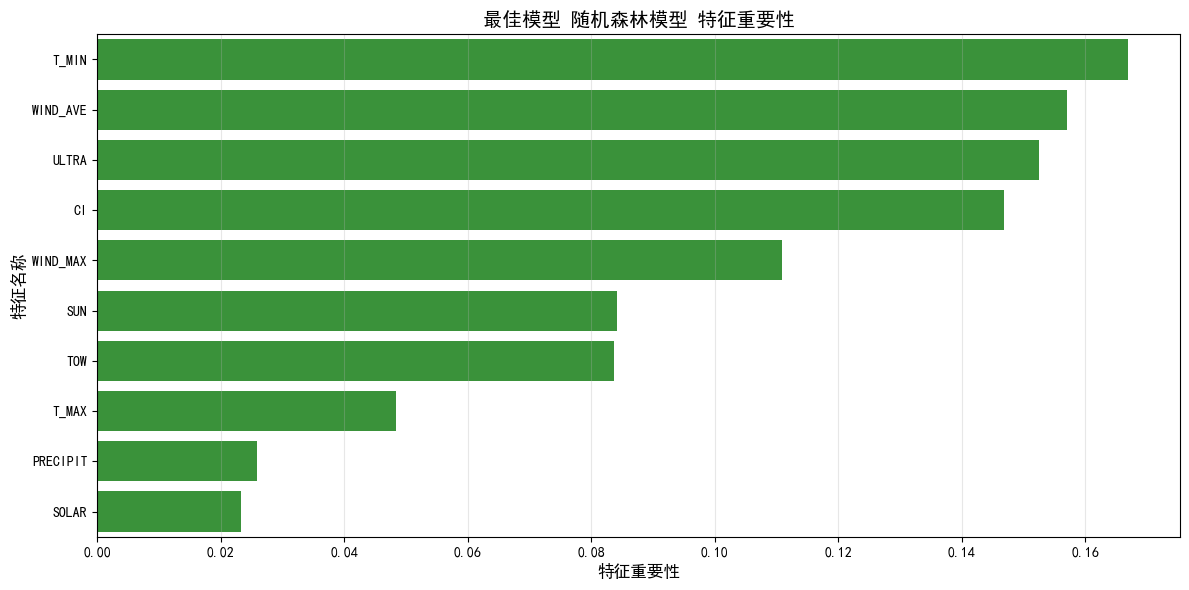

In [12]:
# ---------------------------- 5. 模型性能可视化 ----------------------------
print("\n" + "="*60)
print("5. 模型性能可视化（真实值vs预测值散点图）")
print("="*60)

#绘制模型性能对比图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# 坐标轴范围
max_val = max(max(y_train_original), max(y_test_original))
min_val = min(min(y_train_original), min(y_test_original))
val_range = [min_val - 0.001, max_val + 0.001]

# 子图1：随机森林性能
ax1.scatter(
    y_train_original, y_train_pred_rf_original, 
    alpha=0.6, color='#1f77b4', label=f'训练集（R方={rf_train_r2:.4f}）'
)
ax1.scatter(
    y_test_original, y_test_pred_rf_original, 
    alpha=0.6, color='#d62728', label=f'测试集（R方={rf_test_r2:.4f}）'
)
ax1.plot(val_range, val_range, 'k--', linewidth=2, label='理想拟合线（y=x）')
ax1.set_xlabel('真实腐蚀速率（RATE）', fontsize=12)
ax1.set_ylabel('预测腐蚀速率（RATE）', fontsize=12)
ax1.set_title('随机森林：真实值vs预测值', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.set_xlim(val_range)
ax1.set_ylim(val_range)

# 子图2：岭回归性能
ax2.scatter(
    y_train_original, y_train_pred_ridge_original, 
    alpha=0.6, color='#1f77b4', label=f'训练集（R方={ridge_train_r2:.4f}）'
)
ax2.scatter(
    y_test_original, y_test_pred_ridge_original, 
    alpha=0.6, color='#d62728', label=f'测试集（R方={ridge_test_r2:.4f}）'
)
ax2.plot(val_range, val_range, 'k--', linewidth=2, label='理想拟合线（y=x）')
ax2.set_xlabel('真实腐蚀速率（RATE）', fontsize=12)
ax2.set_ylabel('预测腐蚀速率（RATE）', fontsize=12)
ax2.set_title('岭回归：真实值vs预测值', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)
ax2.set_xlim(val_range)
ax2.set_ylim(val_range)

plt.tight_layout()
plt.show()

# 最佳模型特征重要性/系数可视化
if best_model_name == "随机森林":
    # 随机森林特征重要性
    best_rf_importance = pd.DataFrame({
        'Feature': final_features,
        'Importance': best_rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=best_rf_importance, color='#2ca02c')
    plt.title(f'最佳模型 随机森林模型 特征重要性', fontsize=14, fontweight='bold')
    plt.xlabel('特征重要性', fontsize=12)
    plt.ylabel('特征名称', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    # 岭回归特征系数
    ridge_coef = pd.DataFrame({
        'Feature': final_features,
        'Coefficient': best_ridge.coef_
    }).sort_values(by='Coefficient', ascending=False)
    
    plt.figure(figsize=(12, 6))
    colors = ['#d62728' if c > 0 else '#1f77b4' for c in ridge_coef['Coefficient']]
    sns.barplot(x='Coefficient', y='Feature', data=ridge_coef, palette=colors)
    plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
    plt.title(f'最佳模型 岭回归模型 特征系数（正=促进腐蚀，负=抑制腐蚀）', fontsize=14, fontweight='bold')
    plt.xlabel('特征系数', fontsize=12)
    plt.ylabel('特征名称', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()



6. 过拟合检验曲线
随机森林学习曲线：


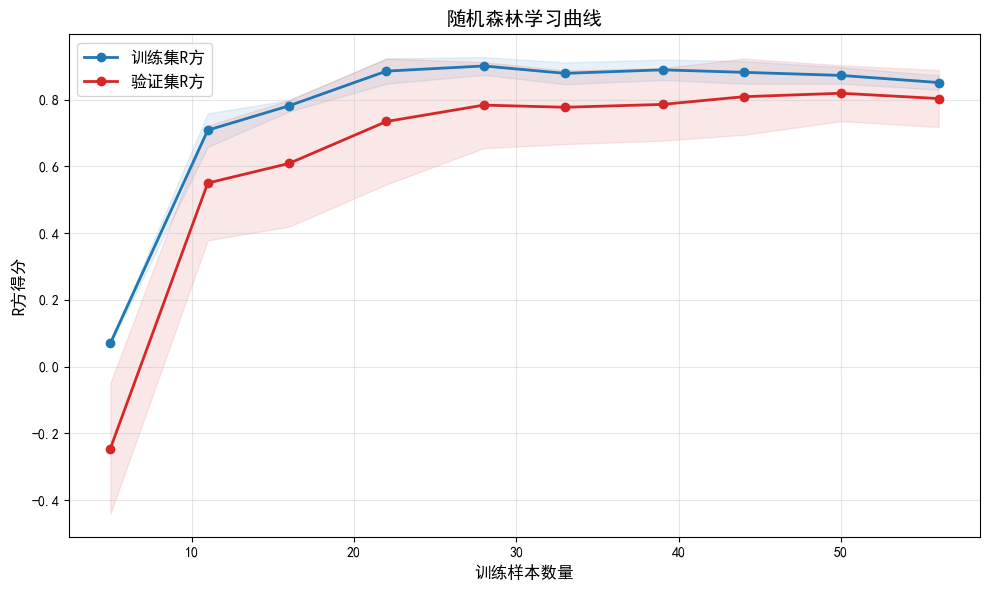

岭回归学习曲线：


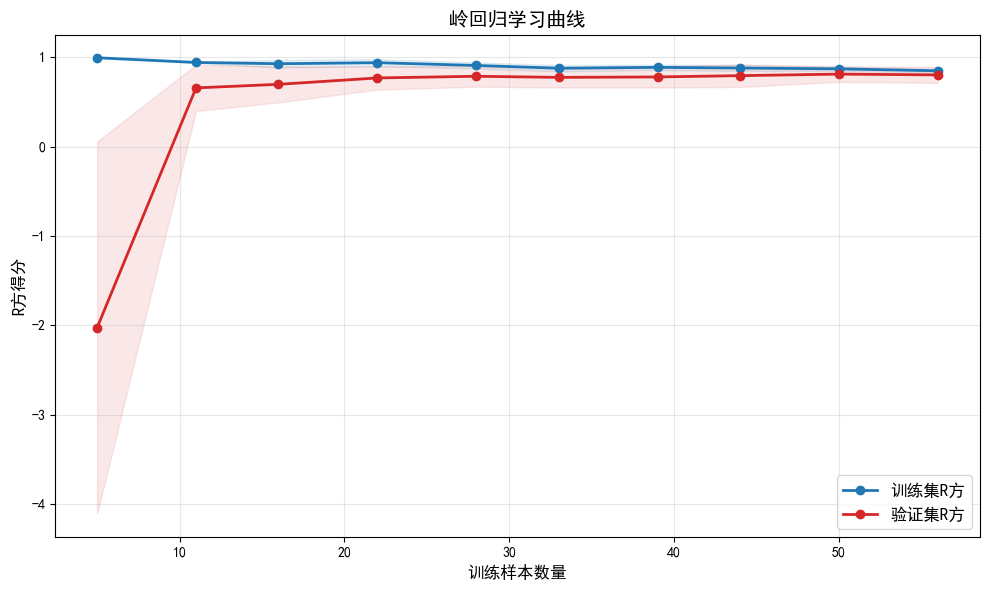

最佳模型学习曲线：


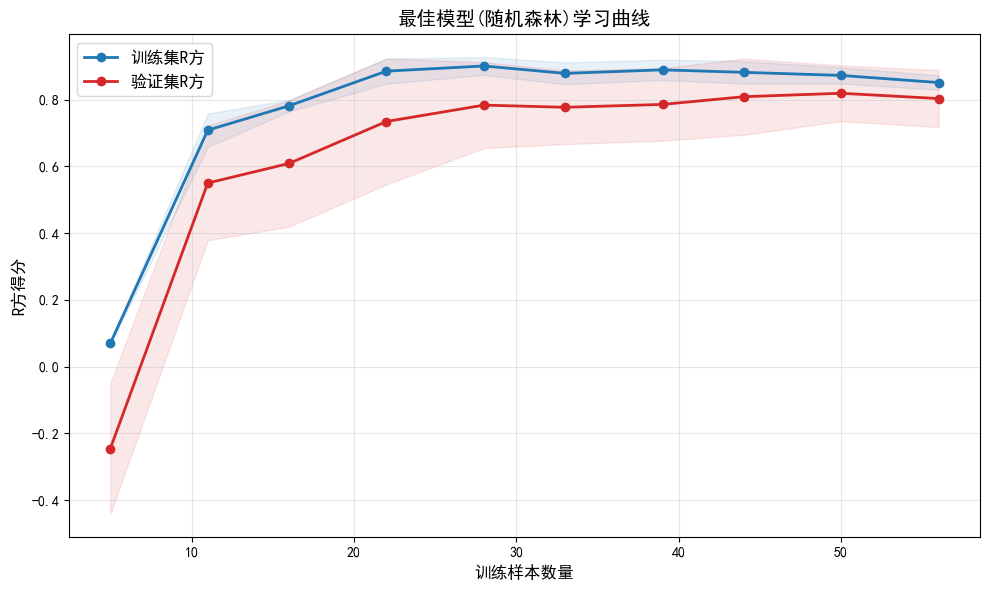

随机森林误差曲线：


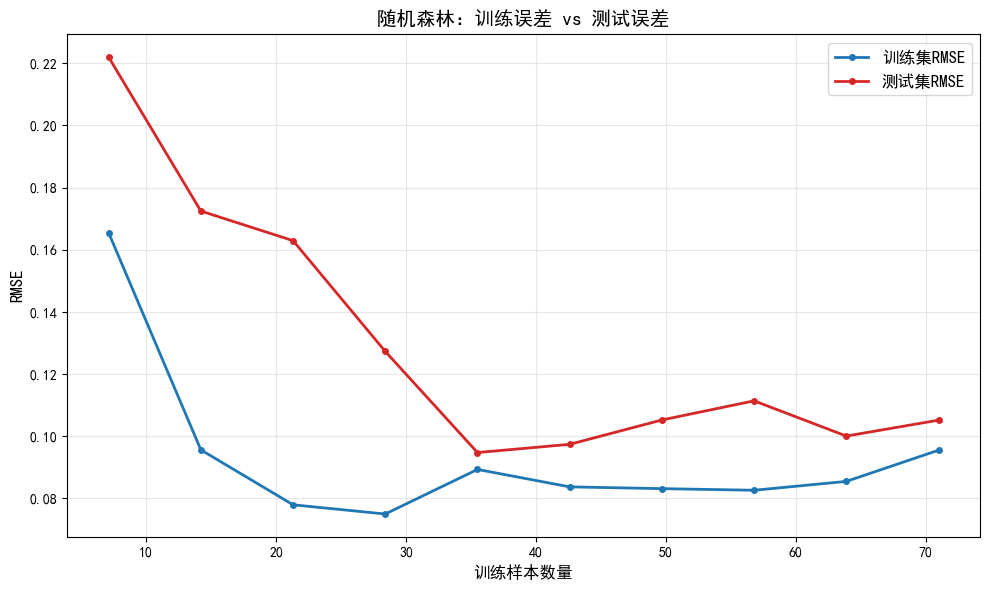

岭回归误差曲线：


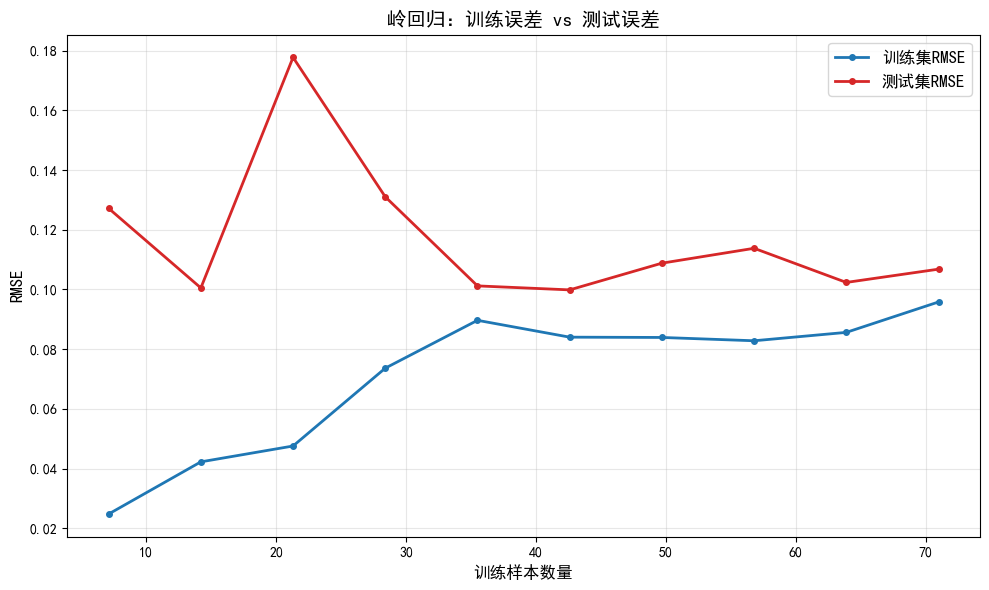

最佳模型误差曲线：


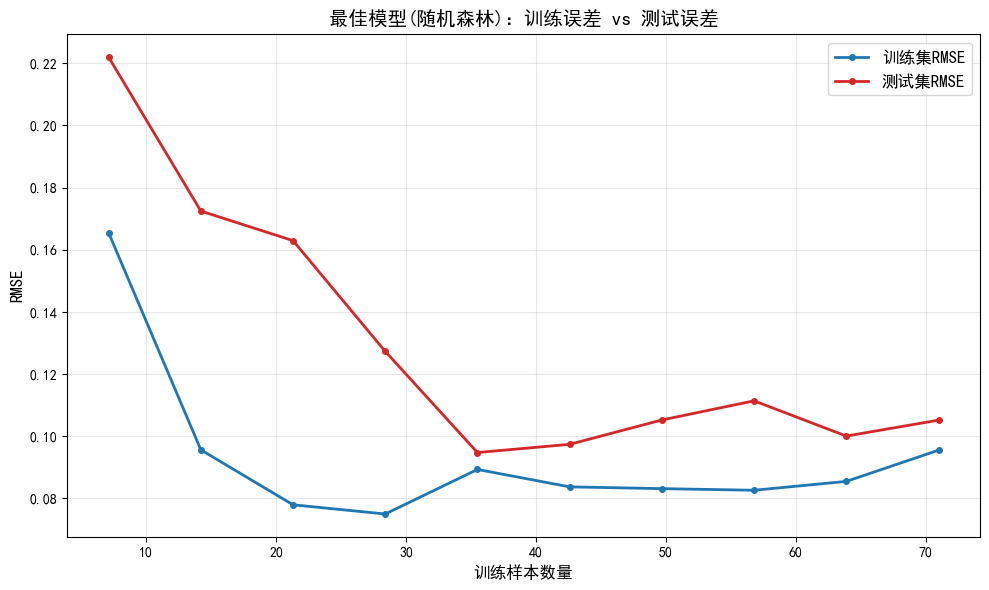

In [6]:
# ---------------------------- 6. 过拟合检验曲线 ----------------------------
print("\n" + "="*60)
print("6. 过拟合检验曲线")
print("="*60)

# 学习曲线函数
def plot_learning_curve(estimator, title, X, y, cv=5):
    plt.figure(figsize=(10, 6))
    
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes,
        scoring='r2', n_jobs=-1, random_state=42
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='#1f77b4', 
             label='训练集R方', linewidth=2, markersize=6)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='#1f77b4')
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color='#d62728', 
             label='验证集R方', linewidth=2, markersize=6)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='#d62728')
    
    plt.xlabel('训练样本数量', fontsize=12)
    plt.ylabel('R方得分', fontsize=12)
    plt.title(f'{title}学习曲线', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 误差曲线函数
def plot_error_curve(estimator, X_train, y_train, X_test, y_test, model_name):
    plt.figure(figsize=(10, 6))
    
    train_errors = []
    test_errors = []
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    for size in train_sizes:
        n_samples = int(len(X_train) * size)
        X_subset = X_train[:n_samples]
        y_subset = y_train[:n_samples]
        
        estimator_temp = clone(estimator)
        estimator_temp.fit(X_subset, y_subset)
        
        train_pred = estimator_temp.predict(X_subset)
        test_pred = estimator_temp.predict(X_test)
        
        train_rmse = np.sqrt(mean_squared_error(y_subset, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        
        train_errors.append(train_rmse)
        test_errors.append(test_rmse)
    
    plt.plot(train_sizes * len(X_train), train_errors, 'o-', color='#1f77b4', 
             label='训练集RMSE', linewidth=2, markersize=4)
    plt.plot(train_sizes * len(X_train), test_errors, 'o-', color='#d62728', 
             label='测试集RMSE', linewidth=2, markersize=4)
    
    plt.xlabel('训练样本数量', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.title(f'{model_name}：训练误差 vs 测试误差', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 绘制学习曲线
print("随机森林学习曲线：")
plot_learning_curve(best_rf, "随机森林", X_train_final, y_train)

print("岭回归学习曲线：")
plot_learning_curve(best_ridge, "岭回归", X_train_final, y_train)

print("最佳模型学习曲线：")
plot_learning_curve(best_model, f"最佳模型({best_model_name})", X_train_final, y_train)

# 绘制误差曲线
print("随机森林误差曲线：")
plot_error_curve(best_rf, X_train_final, y_train, X_test_final, y_test, "随机森林")

print("岭回归误差曲线：")
plot_error_curve(best_ridge, X_train_final, y_train, X_test_final, y_test, "岭回归")

print("最佳模型误差曲线：")
best_model_for_plot = best_rf if best_model_name == "随机森林" else best_ridge
plot_error_curve(best_model_for_plot, X_train_final, y_train, X_test_final, y_test, f"最佳模型({best_model_name})")



7. SHAP 可解释性分析
SHAP分析如下：


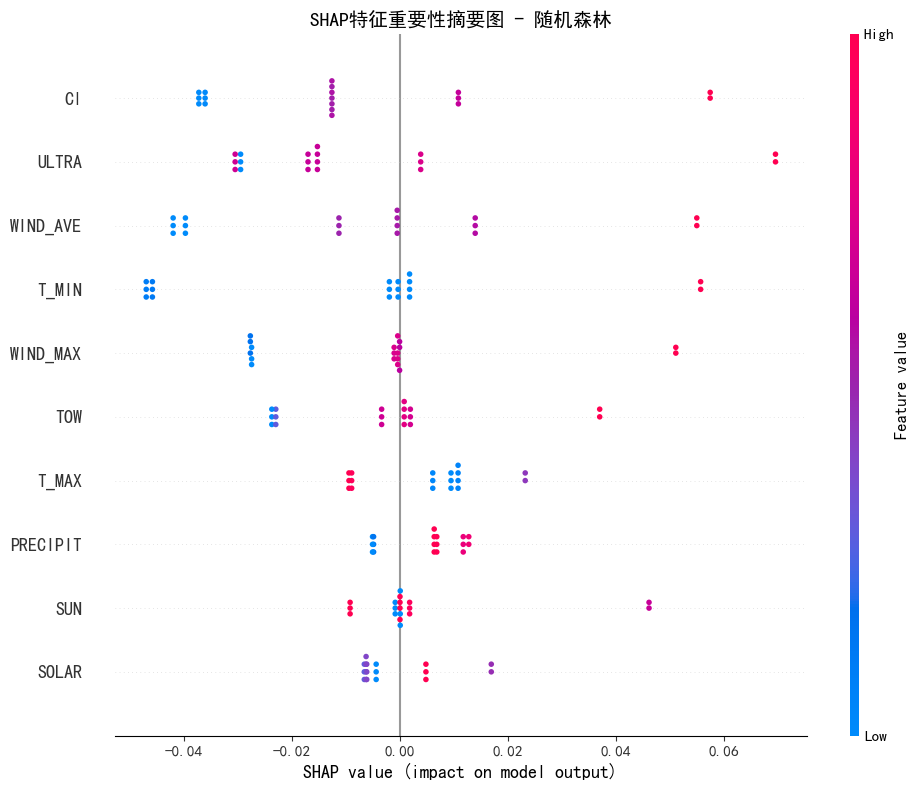

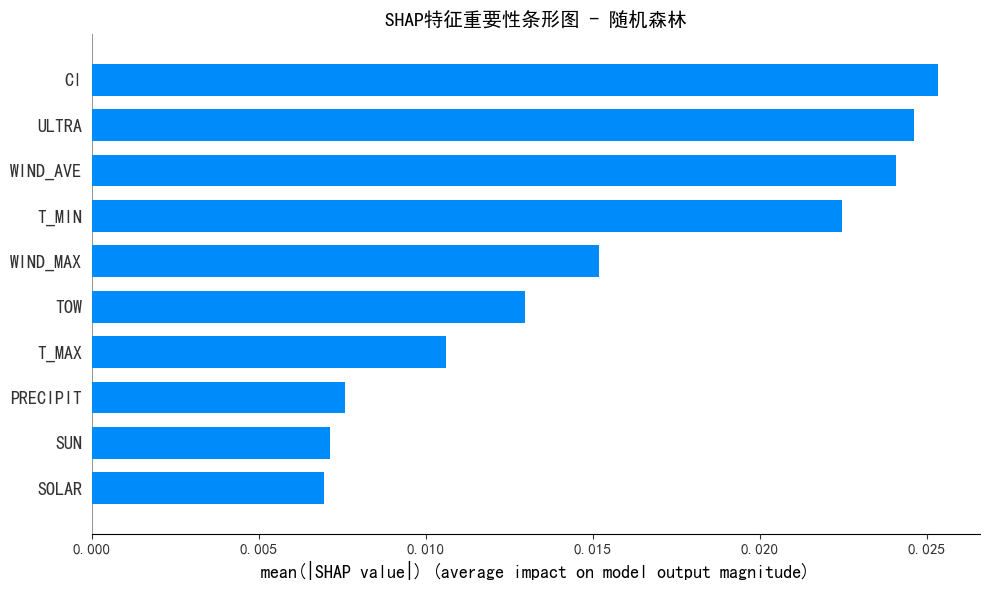

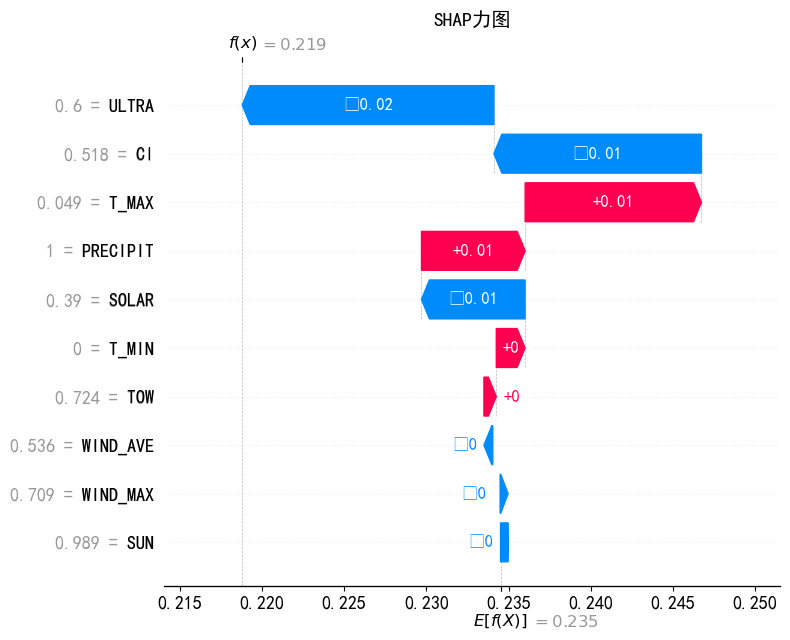

SHAP分析完成！


In [7]:
# ---------------------------- 7. SHAP 可解释性分析 ----------------------------
print("\n" + "="*60)
print("7. SHAP 可解释性分析")
print("="*60)

try:
    import shap
    
    print("SHAP分析如下：")
    
    #  使用最佳模型进行SHAP分析
    if best_model_name == "随机森林":
        # 随机森林的SHAP分析
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_final)
        
        # 创建SHAP摘要图
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test_final, feature_names=final_features, 
                         show=False, plot_size=(10, 8))
        plt.title(f'SHAP特征重要性摘要图 - {best_model_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # 创建SHAP条形图（特征重要性排序）
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_final, feature_names=final_features, 
                         plot_type="bar", show=False, plot_size=(10, 6))
        plt.title(f'SHAP特征重要性条形图 - {best_model_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # 修复单个样本的SHAP力解释图（使用新版本的API）
        plt.figure(figsize=(10, 6))
        # 创建Explanation对象
        explanation = shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value,
                                     data=X_test_final[0],
                                     feature_names=final_features)
        shap.waterfall_plot(explanation, show=False)
        plt.title('SHAP力图', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
    else:
        # 岭回归的SHAP分析（使用KernelExplainer）
        def model_predict(X):
            return best_model.predict(X)
        
        explainer = shap.KernelExplainer(model_predict, X_train_final[:100])  # 使用部分训练数据作为背景
        shap_values = explainer.shap_values(X_test_final[:50])  # 使用部分测试数据
        
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test_final[:50], feature_names=final_features, 
                         show=False, plot_size=(10, 8))
        plt.title(f'SHAP特征重要性摘要图 - {best_model_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    print("SHAP分析完成！")
    
except ImportError:
    print("SHAP库未安装，跳过SHAP分析。")
    print("如需使用SHAP，请运行: pip install shap")
except Exception as e:
    print(f"SHAP分析过程中出现错误: {e}")



8. 数据可视化
特征相关性热力图：


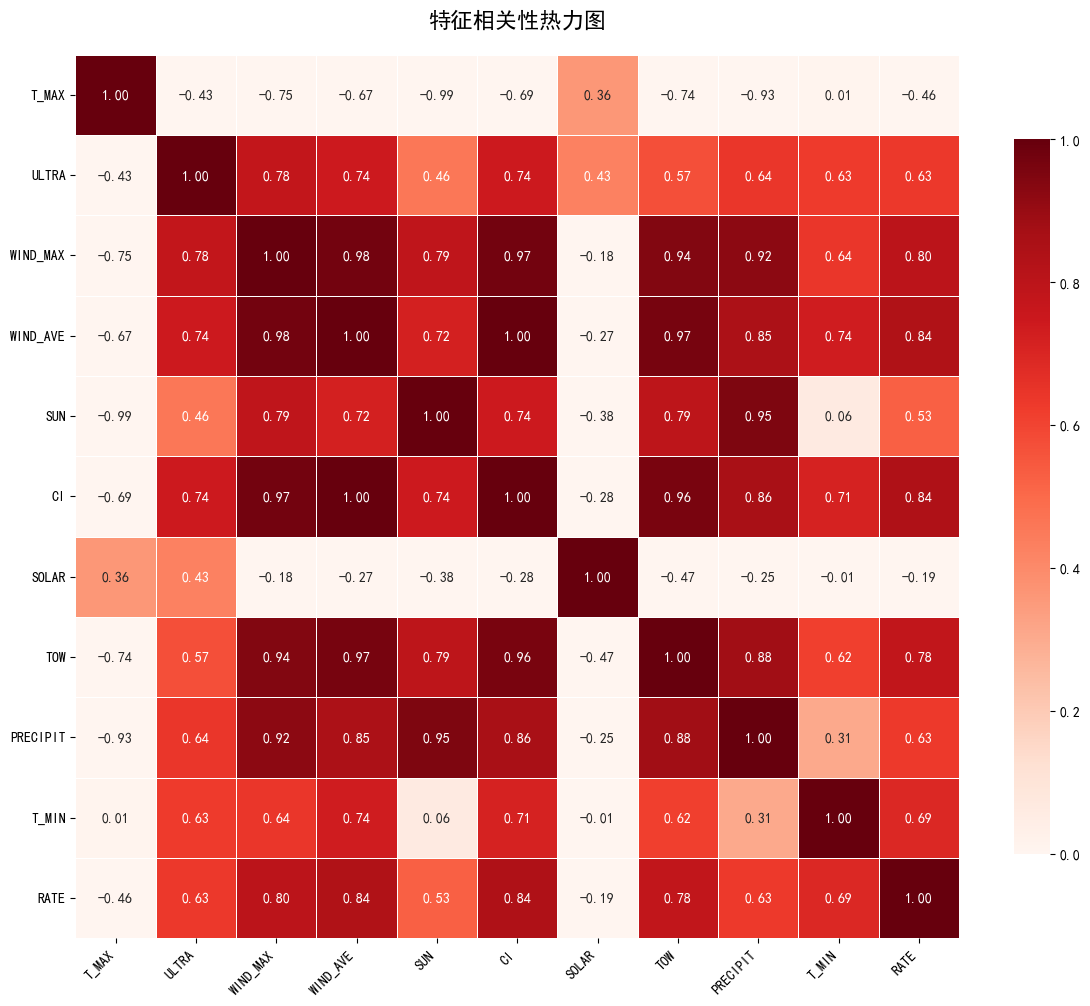

特征分布箱线图：


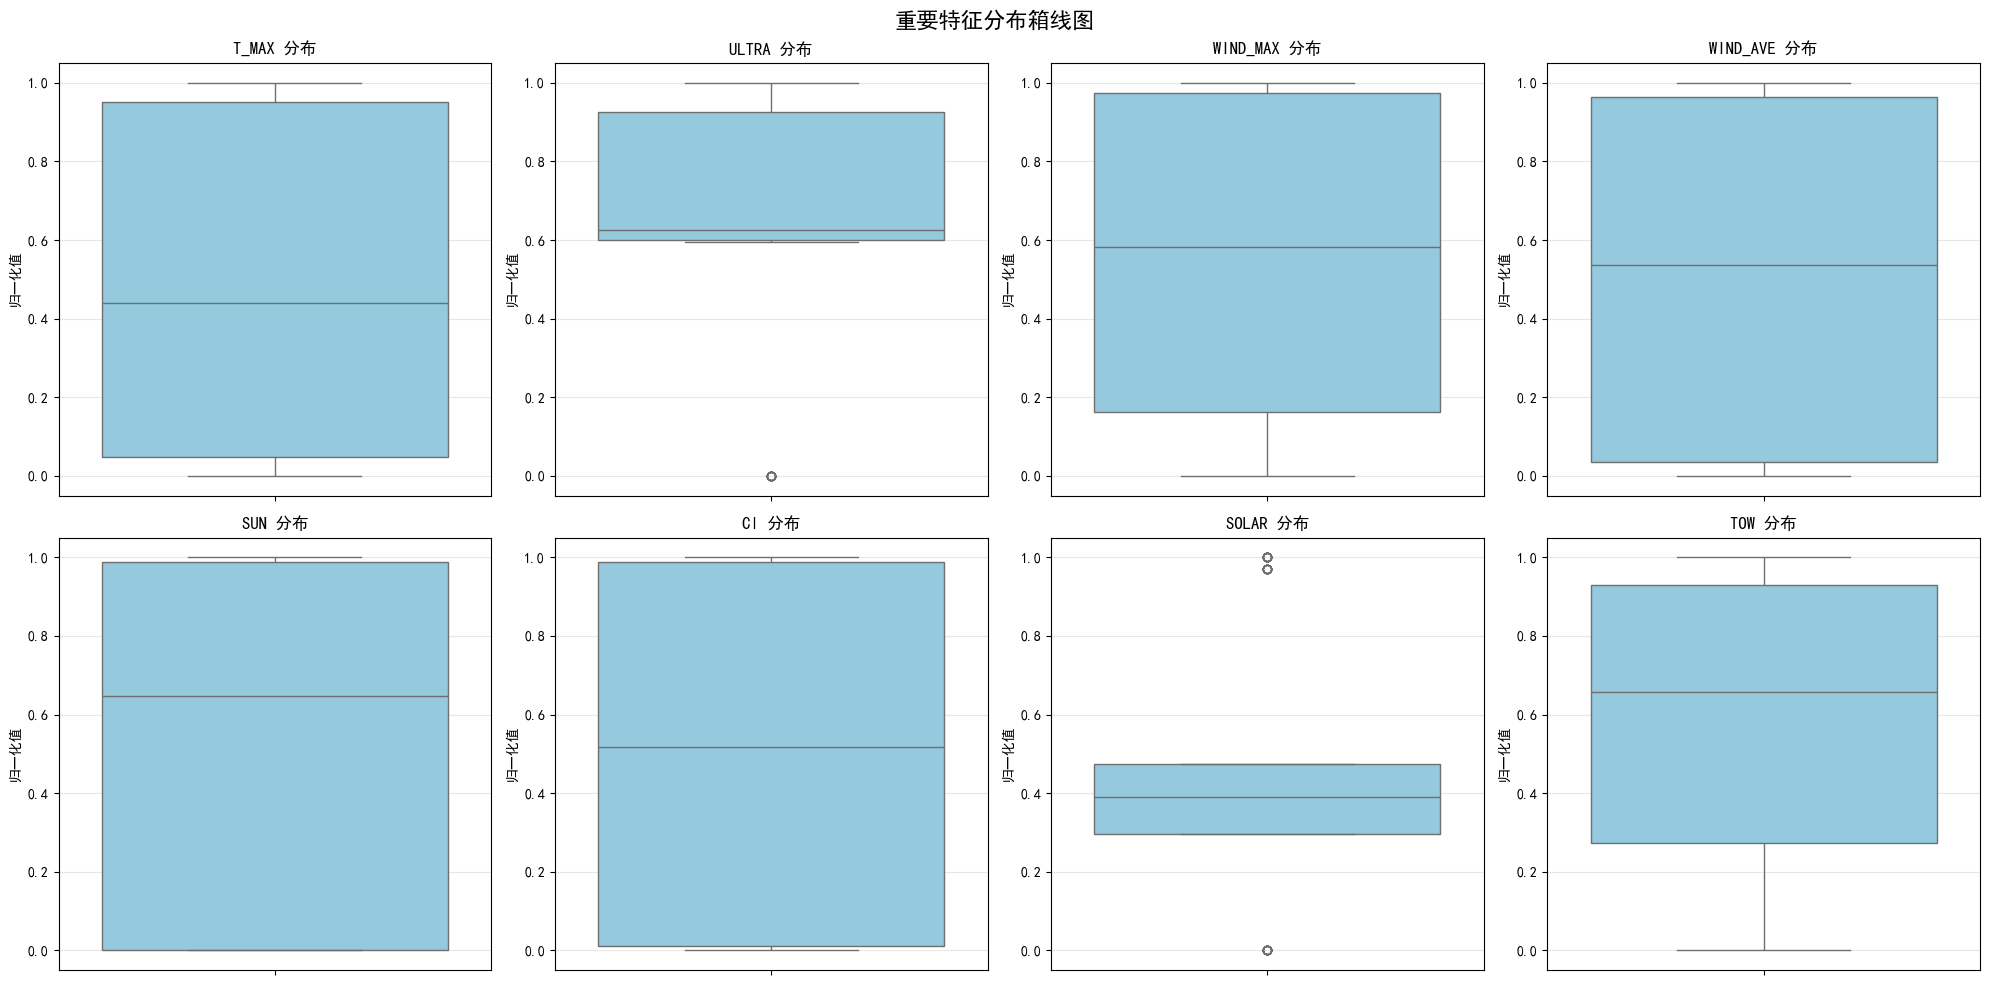

目标变量分布：


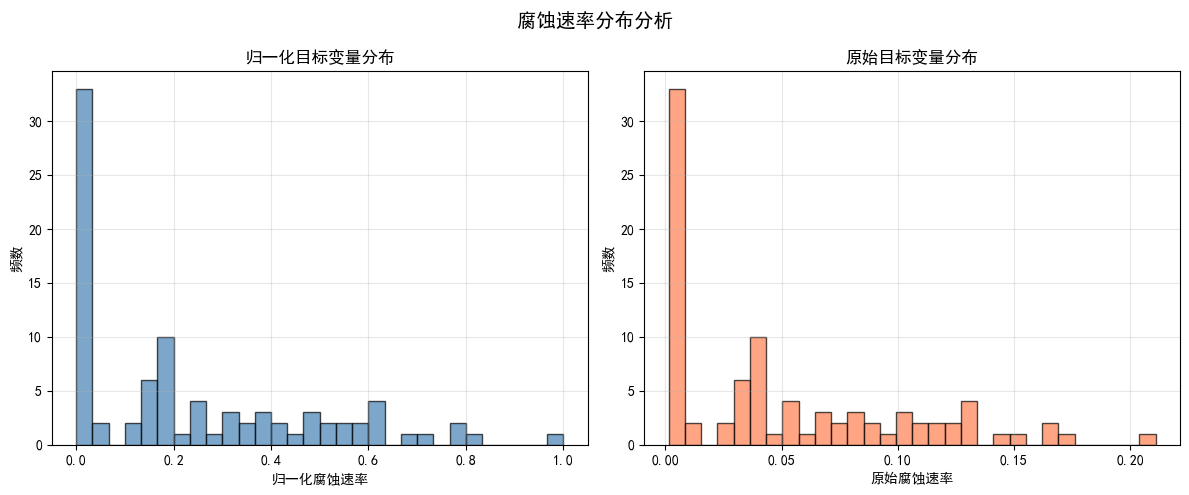

特征-目标变量关系散点图：


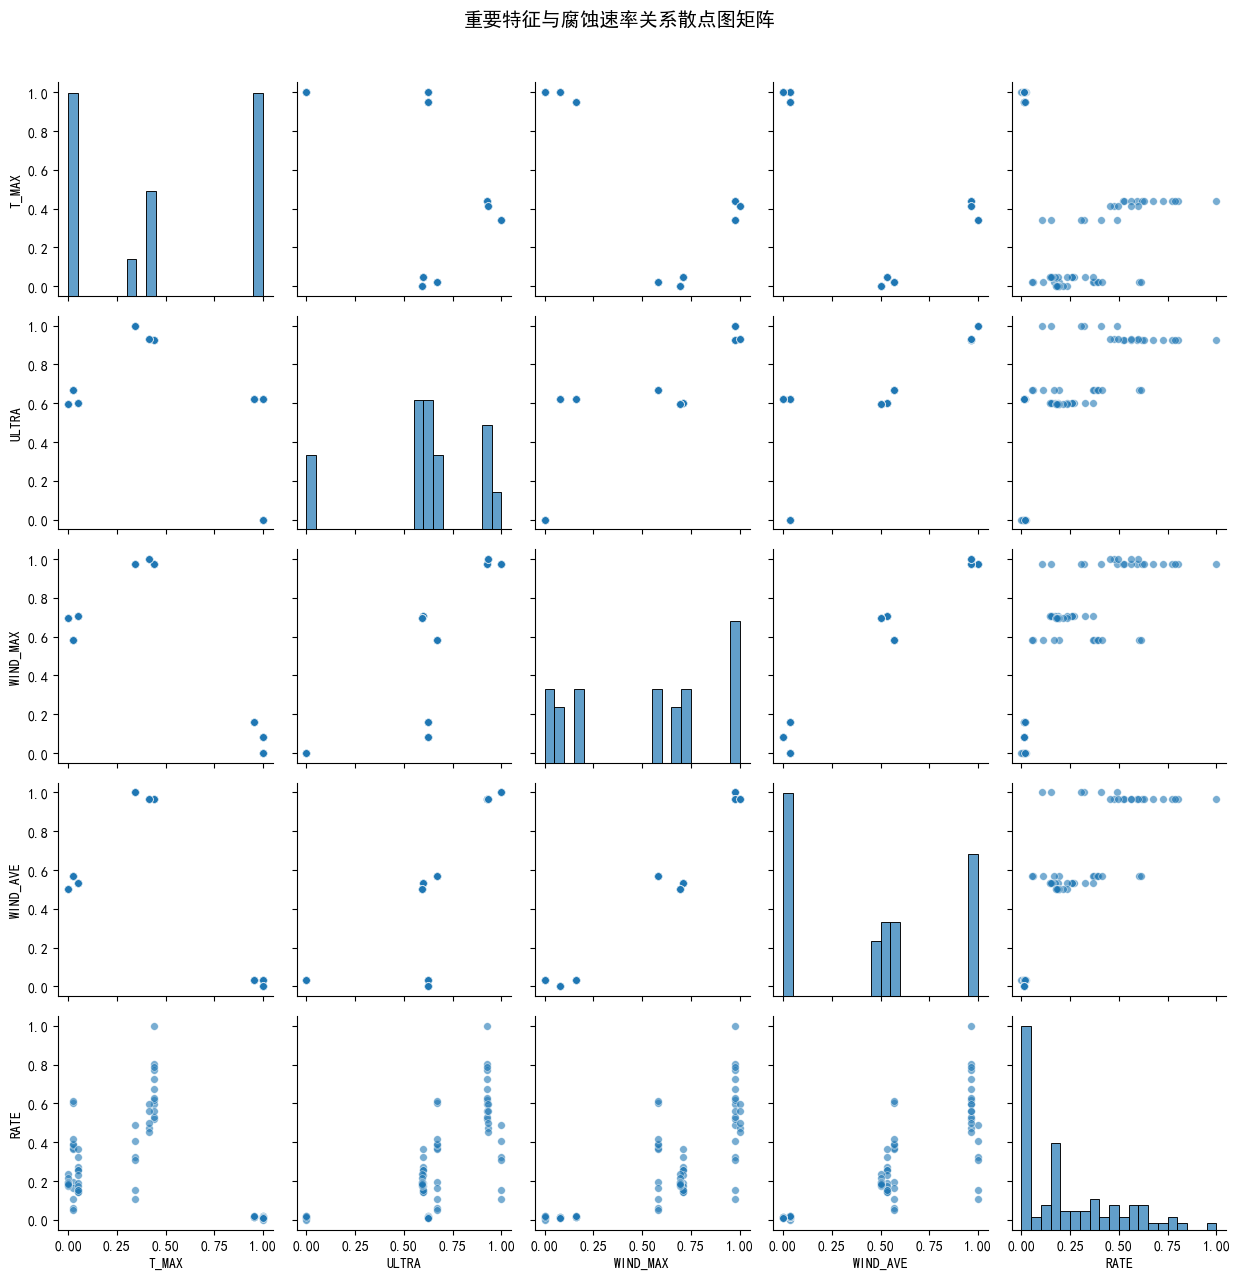


数据探索可视化完成！


In [8]:
# ---------------------------- 8. 数据可视化 ----------------------------
print("\n" + "="*60)
print("8. 数据可视化")
print("="*60)

#  特征相关性热力图
print("特征相关性热力图：")

# 使用筛选后的特征创建DataFrame
df_final_features = pd.DataFrame(X_scaled, columns=X.columns)[final_features]
df_final_features['RATE'] = y_scaled

# 计算相关性矩阵
correlation_matrix = df_final_features.corr()

plt.figure(figsize=(12, 10))
# 移除三角掩码，创建完整的正方形热力图
# 使用红色系颜色映射，vmin和vmax设置合适的范围
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='Reds',  # 使用红色系
            vmin=0,       # 最小值为0
            vmax=1,       # 最大值为1
            square=True, 
            cbar_kws={"shrink": .8},
            linewidths=0.5,  # 添加网格线
            linecolor='white')  # 网格线颜色

plt.title('特征相关性热力图', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#  箱线图 - 特征分布可视化
print("特征分布箱线图：")

# 选择前8个重要特征进行可视化（避免图表过于拥挤）
top_features = final_features[:8] if len(final_features) >= 8 else final_features

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    if i < len(axes):
        sns.boxplot(y=df_final_features[feature], ax=axes[i], color='skyblue')
        axes[i].set_title(f'{feature} 分布', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('归一化值' if feature != 'RATE' else '腐蚀速率')
        axes[i].grid(axis='y', alpha=0.3)

# 隐藏多余的子图
for i in range(len(top_features), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('重要特征分布箱线图', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# 目标变量分布直方图
print("目标变量分布：")

plt.figure(figsize=(12, 5))

# 子图1：归一化后的目标变量分布
plt.subplot(1, 2, 1)
plt.hist(y_scaled, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('归一化腐蚀速率')
plt.ylabel('频数')
plt.title('归一化目标变量分布', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# 子图2：原始目标变量分布
plt.subplot(1, 2, 2)
plt.hist(y, bins=30, alpha=0.7, color='coral', edgecolor='black')
plt.xlabel('原始腐蚀速率')
plt.ylabel('频数')
plt.title('原始目标变量分布', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.suptitle('腐蚀速率分布分析', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 特征与目标变量的散点图矩阵（选择最重要的4个特征）
print("特征-目标变量关系散点图：")

important_features = final_features[:4] if len(final_features) >= 4 else final_features
if len(important_features) > 1:
    scatter_features = important_features + ['RATE']
    scatter_df = df_final_features[scatter_features]
    
    # 创建散点图矩阵
    fig = sns.pairplot(scatter_df, 
                      diag_kind='hist',
                      plot_kws={'alpha': 0.6, 's': 30},
                      diag_kws={'alpha': 0.7, 'bins': 20})
    
    fig.fig.suptitle('重要特征与腐蚀速率关系散点图矩阵', 
                    y=1.02, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n数据探索可视化完成！")


In [9]:
# ---------------------------- 9. 结果汇总与保存 ----------------------------
print("\n" + "="*60)
print("9. 结果汇总")
print("="*60)


# 整理模型性能结果
result_summary = pd.DataFrame({
    '模型名称': ['随机森林', '岭回归'],
    '最佳超参数': [
        str(rf_grid.best_params_),
        f"alpha={ridge_cv.alpha_:.6f}"
    ],
    '训练集RMSE': [rf_train_rmse, ridge_train_rmse],
    '训练集R²': [rf_train_r2, ridge_train_r2],
    '测试集RMSE': [rf_test_rmse, ridge_test_rmse],
    '测试集R²': [rf_test_r2, ridge_test_r2],
    '是否最佳模型': ['是' if rf_test_r2 > ridge_test_r2 else '否', '是' if rf_test_r2 <= ridge_test_r2 else '否']
})

print("\n 模型性能结果汇总：")
print(result_summary)

# 最终筛选特征列表
final_features_df = pd.DataFrame({
    '最终输入特征': final_features,
    '特征类型': [
        '元素成分' if feat in ['C', 'Si', 'Mn', 'P', 'S', 'Cu', 'Cr', 'Ni', 'Cl'] else '环境参数' 
        for feat in final_features
    ]
})

print("\n 最终筛选特征列表：")
print(final_features_df)

# 输出最佳模型名称
print(f"\n最终确定的最佳模型为：{best_model_name}模型")



9. 结果汇总

 模型性能结果汇总：
   模型名称                                              最佳超参数   训练集RMSE  \
0  随机森林  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  0.020012   
1   岭回归                                     alpha=0.000521  0.020074   

      训练集R²   测试集RMSE     测试集R² 是否最佳模型  
0  0.846950  0.022039  0.821833      是  
1  0.846008  0.022376  0.816335      否  

 最终筛选特征列表：
     最终输入特征  特征类型
0     T_MAX  环境参数
1     ULTRA  环境参数
2  WIND_MAX  环境参数
3  WIND_AVE  环境参数
4       SUN  环境参数
5        Cl  元素成分
6     SOLAR  环境参数
7       TOW  环境参数
8  PRECIPIT  环境参数
9     T_MIN  环境参数

最终确定的最佳模型为：随机森林模型


In [10]:
# ---------------------------- 10. 最佳模型预测示例 ----------------------------
print(f"\n" + "="*60)
print("10. 最佳模型预测示例（3个测试集样本）")
print("="*60)

# 随机选择3个测试集样本
np.random.seed(42)
sample_idx = np.random.choice(len(X_test_final), 3, replace=False)
sample_X = X_test_final[sample_idx]
sample_y_original = y_test_original[sample_idx]

# 最佳模型预测
sample_y_pred = best_model.predict(sample_X)
sample_y_pred_original = scaler_y.inverse_transform(sample_y_pred.reshape(-1, 1)).flatten()

# 输出预测结果
print(f"\n最佳模型 {best_model_name}模型 的测试集样本预测结果：")

for i in range(3):
    error = abs(sample_y_original[i] - sample_y_pred_original[i])
    print(f"样本{i+1}：")
    print(f"  真实腐蚀速率：{sample_y_original[i]:.6f}")
    print(f"  预测腐蚀速率：{sample_y_pred_original[i]:.6f}")
    print(f"  绝对误差：{error:.6f}")
    print(f"  相对误差：{error/sample_y_original[i]*100:.2f}%")
    print()


10. 最佳模型预测示例（3个测试集样本）

最佳模型 随机森林模型 的测试集样本预测结果：
样本1：
  真实腐蚀速率：0.031862
  预测腐蚀速率：0.047297
  绝对误差：0.015436
  相对误差：48.45%

样本2：
  真实腐蚀速率：0.069730
  预测腐蚀速率：0.047297
  绝对误差：0.022433
  相对误差：32.17%

样本3：
  真实腐蚀速率：0.005025
  预测腐蚀速率：0.004320
  绝对误差：0.000704
  相对误差：14.02%

